In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# Read the data

In [49]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# Exploring the data structure

In [3]:
# Get a first impression on the structure of the table. 
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [56]:
# Get an overview on the data types for every column. 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [57]:
# Check for null values
train = train.fillna(value={'Age': test.Age.mean()})
test = test.fillna(value={'Age': test.Age.mean(), 'Fare': test.Fare.mean()})

# Explore the data

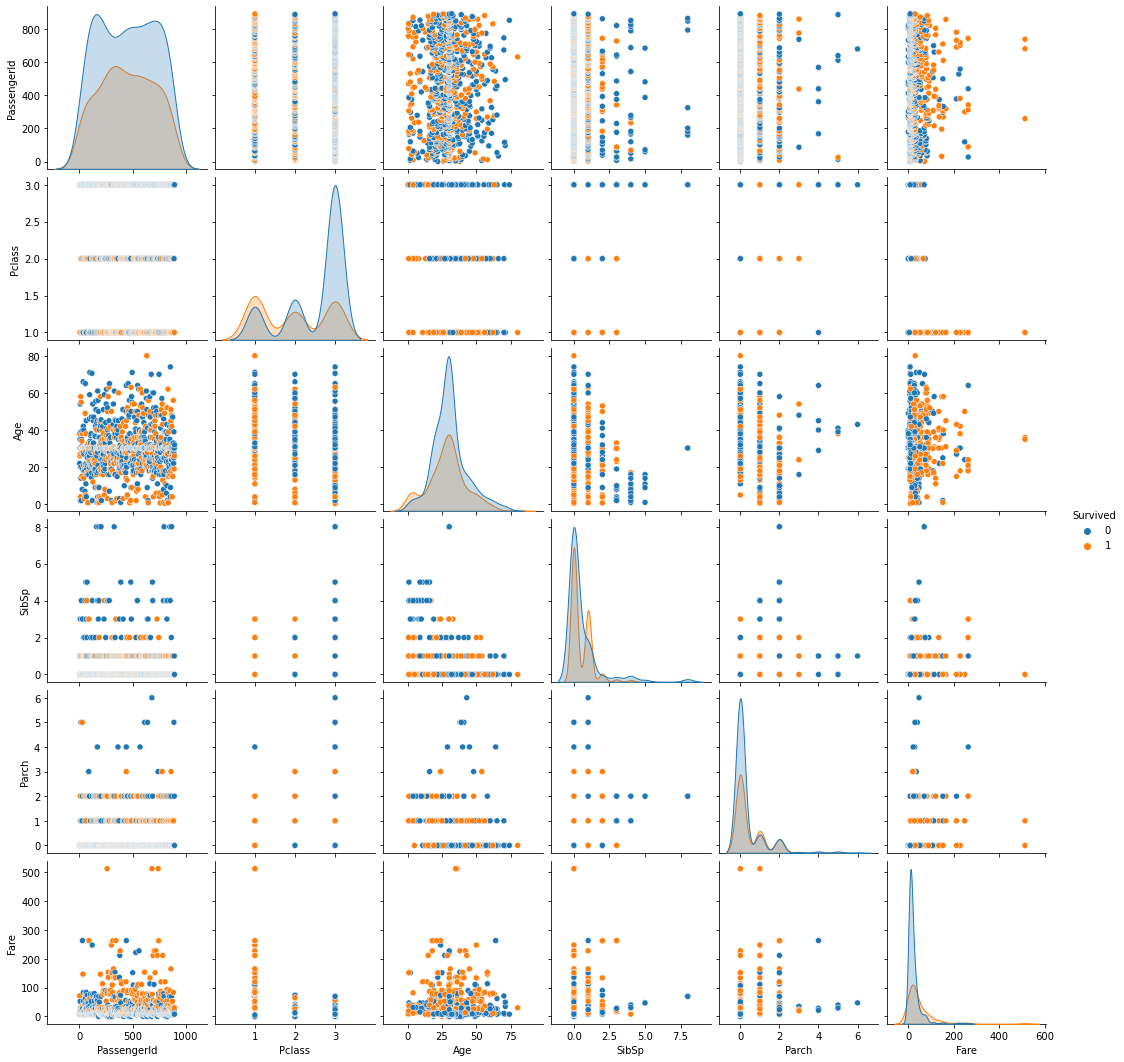

In [58]:
# Generate an overview plot

sns.pairplot(train, hue='Survived')

# Numerize categorical data

In [60]:
# These are the features that we will consider for the model: 
# Pclass
# Sex
# Age
# SibSp
# Parch
# Fare

# Generate a local copy of the datasets
train_sel = train.copy()
test_sel = test.copy()

# Drop all the features that we will not use for the model
train_target = train_sel['Survived']
test_id = test_sel['PassengerId']
train_sel = train_sel.drop(columns=['PassengerId','Name', 'Ticket', 'Cabin', 'Embarked', 'Survived'])
test_sel = test_sel.drop(columns=['PassengerId','Name', 'Ticket', 'Cabin', 'Embarked'])

# Binarizing
train_num = pd.get_dummies(train_sel)
test_num = pd.get_dummies(test_sel)

# Scaling
scaler = preprocessing.MinMaxScaler().fit(train_num)

train_scaled = pd.DataFrame(scaler.transform(train_num), columns=train_num.columns)
test_scaled = pd.DataFrame(scaler.transform(test_num), columns=test_num.columns)

# Splitting data

In [61]:
# Splitting training data into training and validation data
X_train, X_val, y_train, y_val = train_test_split(train_scaled, 
                                                  train_target, 
                                                  test_size = 0.25)

# Modelling the data

In [62]:
# Here we test several classifiers and perform a grid search for 
# finding the best perform hyper parameters

models = [
    LogisticRegression, 
    GaussianNB, 
    DecisionTreeClassifier, 
    RandomForestClassifier, 
    KNeighborsClassifier, 
    MLPClassifier, 
    LinearSVC]

args = [
    {'penalty': ['none','l1','l2'], 
     'fit_intercept': [True, False],
     'solver': ['newton-cg','lbfgs','liblinear','sag','saga']},
    
    {'var_smoothing':[1.e-6,1.e-7,1.e-8,1.e-9]},
    
    {'max_depth': range(10), 
     'criterion': ['gini', 'entropy']},
    
    {'n_estimators': np.array(range(5))*10, 
     'criterion': ['gini','entropy'], 
     'max_depth': range(10)},
    
    {'n_neighbors': range(10), 
     'weights': ['uniform','distance'], 
     'algorithm': ['ball_tree','kd_tree','brute','auto']},
    
    {'max_iter': [400,500,600], 
     'activation': ['identity','logistic','relu','tanh'], 
     'solver': ['lbfgs','sgd','adam'],
     'shuffle': [True, False]},
    
    {'penalty': ['l1','l2'],} 
]

for m in range(len(models)):
    
    print(' ')
    print(models[m].__name__+' best parameters: ')
    
    grid = GridSearchCV(models[m](), args[m], cv=3)
    grid.fit(X_train, y_train)

    print(grid.best_params_)
    
    best_model = grid.best_estimator_ 
    y_pred_best = best_model.fit(X_train, y_train).predict(X_val)
    
    print('Accuray score: '+str(metrics.accuracy_score(y_val, y_pred_best)))


 
LogisticRegression best parameters: 
{'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'}
Accuray score: 0.7399103139013453
 
GaussianNB best parameters: 
{'var_smoothing': 1e-06}
Accuray score: 0.7399103139013453
 
DecisionTreeClassifier best parameters: 
{'criterion': 'gini', 'max_depth': 3}
Accuray score: 0.757847533632287
 
RandomForestClassifier best parameters: 
{'criterion': 'gini', 'max_depth': 9, 'n_estimators': 20}
Accuray score: 0.7802690582959642
 
KNeighborsClassifier best parameters: 
{'algorithm': 'ball_tree', 'n_neighbors': 2, 'weights': 'uniform'}
Accuray score: 0.757847533632287
 
MLPClassifier best parameters: 
{'activation': 'relu', 'max_iter': 500, 'shuffle': True, 'solver': 'adam'}
Accuray score: 0.7623318385650224
 
LinearSVC best parameters: 
{'penalty': 'l2'}
Accuray score: 0.7443946188340808


In [93]:
# According to the accuracy score, we decide to take the 
# RandomForestClassifier as our model for the prediction of the test 
# dataset. 

# Predicting the test data with the best scored model

In [63]:
# setting the final model
final_model = RandomForestClassifier(criterion='gini', 
                                     max_depth=9, n_estimators=20)

# predicting the values for the test dataset
y_test = pd.DataFrame(final_model.fit(X_train, y_train).predict(test_scaled),
                      columns=['Survived',])

# Saving result to a .csv file
final_data = pd.DataFrame(test_id, columns=['PassengerId',])
final_data = final_data.join(y_test)
final_data.to_csv('titanic_final.csv', index=False)